<a href="https://colab.research.google.com/github/mkuczynski11/iui-project/blob/master/IUI_project_bert_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notatnik do projektu z IUI - Klasyfikacja dokumentów prawnych z wizualizacją za pomocą algorytmu SOM

### Importowanie bibliotek i danych

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import re, string
import shutil

# model-building
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv('./drive/MyDrive/IUI/dbdata.csv', encoding='Windows-1250')
df.head()

,id,sample,label
0,0,czy wspólnota mieszkaniowa może podjąć uchwałę...,prawo cywilne
1,1,czy wspólnota mieszkaniowa może odzyskać pomie...,prawo cywilne
2,2,czy uprawnienie mieszkańców wspólnoty mieszkan...,prawo administracyjne
3,3,czy budowa windy dla osób niepełnosprawnych mo...,prawo administracyjne
4,4,jakie czynności powinna podjąć wspólnota miesz...,prawo cywilne


### Eksploracja danych

#### Dystybucja klas

[Text(0, 0, 'prawo cywilne'),
 Text(1, 0, 'prawo administracyjne'),
 Text(2, 0, 'prawo farmaceutyczne'),
 Text(3, 0, 'prawo pracy'),
 Text(4, 0, 'prawo medyczne'),
 Text(5, 0, 'prawo karne'),
 Text(6, 0, 'inne'),
 Text(7, 0, 'prawo podatkowe')]

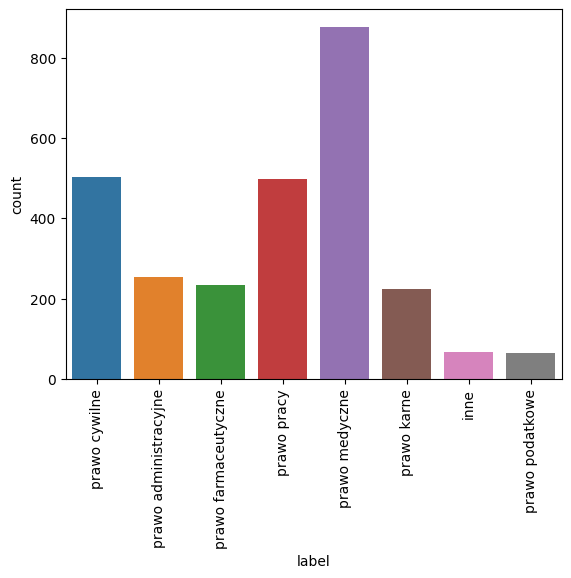

In [ ]:
g = sns.countplot(x = 'label', data = df)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

#### Wartości brakujące

In [ ]:
print(df.isna().sum())
print(f'Samples before cleanup: {len(df)}')
df = df[df['sample'].notnull()]
print(f'Samples after removing null sample values: {len(df)}')

id        0
sample    2
label     0
dtype: int64
Samples before cleanup: 2721
Samples after removing null sample values: 2719


### Tworzenie modelu BERT na podstawie pre-trenowanego modelu

In [ ]:
!pip install transformers
from transformers import *
!pip install accelerate -U
from transformers import TrainingArguments
import os
!pip install evaluate
import evaluate

import torch
from torch.utils.data import Dataset
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score

/usr/local/lib/python3.10/dist-packages/transformers/deepspeed.py:23: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_flax_utils.py:24: FutureWarning: Importing `FlaxGenerationMixin` from `sr

In [ ]:
base_model = BertForSequenceClassification.from_pretrained("dkleczek/bert-base-polish-cased-v1", num_labels=8)
tokenizer = BertTokenizer.from_pretrained("dkleczek/bert-base-polish-cased-v1")
# base_model = BartForSequenceClassification.from_pretrained("sdadas/polish-bart-base", num_labels=8)
# tokenizer = AutoTokenizer.from_pretrained('sdadas/polish-bart-base')

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--sdadas--polish-bart-base/snapshots/0ed0eb0400b315c51e8017242127874620d2285a/config.json
Model config BartConfig {
  "_name_or_path": "original/polish-bart-base",
  "activation_dropout": 0.1,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "BartForConditionalGeneration"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "classif_dropout": 0.1,
  "classifier_dropout": 0.0,
  "d_model": 768,
  "decoder_attention_heads": 12,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 2,
  "do_blenderbot_90_layernorm": false,
  "dropout": 0.1,
  "early_stopping": true,
  "encoder_attention_heads": 12,
  "encoder_ffn_dim": 3072,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 2,
  "extra_pos_embeddings": 2,
  "force_bos_token_to_be_generated": false,
  "forced_eo

In [ ]:
base_model

BartForSequenceClassification(
  (model): BartModel(
    (shared): Embedding(50002, 768, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(50002, 768, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 768)
      (layers): ModuleList(
        (0-5): 6 x BartEncoderLayer(
          (self_attn): BartAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_layer_norm): LayerNorm((768,), eps

In [ ]:
base_model = base_model.to('cuda')

In [ ]:
label_map = {
    'inne': 0,
    'prawo administracyjne': 1,
    'prawo cywilne': 2,
    'prawo farmaceutyczne': 3,
    'prawo karne': 4,
    'prawo medyczne': 5,
    'prawo podatkowe': 6,
    'prawo pracy': 7
}

X = list(df['sample'])
y = list(df['label'].apply(lambda x: label_map[x]))
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2, stratify=y)
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)

In [ ]:
X_train_tokenized.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
print(X_train_tokenized['input_ids'][0])

[0, 70, 4505, 9657, 807, 1508, 6124, 1308, 387, 5982, 10367, 43, 859, 6, 5245, 6895, 138, 9657, 227, 5982, 20577, 12595, 12886, 3787, 3722, 8, 43, 213, 14705, 43, 3839, 2408, 859, 227, 5982, 10367, 11787, 16591, 10053, 8, 3461, 19, 3392, 130, 32317, 6, 1614, 4371, 6583, 1630, 5982, 1740, 43, 859, 6, 6816, 2041, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
len(X_train), len(X_val)

(2175, 544)

In [ ]:
class TextDataset(Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item =  {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
          item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

In [ ]:
# Convert the dictionary data to PyTorch Dataset
train_dataset = TextDataset(X_train_tokenized, y_train)
val_dataset = TextDataset(X_val_tokenized, y_val)

In [ ]:
train_dataset[5]

{'input_ids': tensor([    0,    70,  5982,  2716,   398, 15028, 10574,   390, 39115,  6922,
          1332, 15649,     2,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,   

In [ ]:
f1_metric = evaluate.load("f1")
recall_metric = evaluate.load("recall")
precision_metric = evaluate.load('precision')
accuracy_metric = evaluate.load('accuracy')
def compute_metrics(p):
    logits, labels = p
    preds = np.argmax(logits, axis = -1)

    results = {}
    results.update(f1_metric.compute(predictions=preds, references = labels, average="micro"))
    results.update(recall_metric.compute(predictions=preds, references = labels, average="micro"))
    results.update(precision_metric.compute(predictions=preds, references = labels, average="micro"))
    results.update(accuracy_metric.compute(predictions=preds, references = labels))
    return results

In [ ]:
# Jeśli pojawia się błąd to trzeba zresetować środowisko i uruchomić ponownie
args = TrainingArguments(
    output_dir="output",
    num_train_epochs=3,
    per_device_train_batch_size=8
)
trainer = Trainer(
    model=base_model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

Found safetensors installation, but --save_safetensors=False. Safetensors should be a preferred weights saving format due to security and performance reasons. If your model cannot be saved by safetensors please feel free to open an issue at https://github.com/huggingface/safetensors!
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
trainer.train()

***** Running training *****
  Num examples = 2,175
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 816
  Number of trainable parameters = 139,815,176


Step,Training Loss
500,0.996500


Saving model checkpoint to output/checkpoint-500
Configuration saved in output/checkpoint-500/config.json
Model weights saved in output/checkpoint-500/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=816, training_loss=0.8275218290441176, metrics={'train_runtime': 306.0543, 'train_samples_per_second': 21.32, 'train_steps_per_second': 2.666, 'total_flos': 797363806766400.0, 'train_loss': 0.8275218290441176, 'epoch': 3.0})

In [ ]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 544
  Batch size = 8


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


ValueError: ignored

In [ ]:
text = "Ala ma kota"
inputs = tokenizer(text, padding=True, truncation=True, return_tensors='pt').to('cuda')
outputs = base_model(**inputs)
print(outputs)
predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
print(predictions)
predictions = predictions.cpu().detach().numpy()
predictions

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Seq2SeqSequenceClassifierOutput(loss=None, logits=tensor([[ 0.6686,  1.3061, -0.7936, -0.5242,  1.2877,  1.8638, -2.3686, -1.2248]],
       device='cuda:0', grad_fn=<AddmmBackward0>), past_key_values=((tensor([[[[-7.8960e-01,  2.7462e+00, -1.8144e+00,  ..., -5.8977e+00,
            1.3696e+00,  1.9994e+00],
          [-6.8142e-01,  2.7464e+00, -1.9744e+00,  ..., -5.3414e+00,
            1.5713e+00,  2.2256e+00],
          [-4.1600e-01, -2.4797e+00,  6.1651e-01,  ..., -9.2673e-01,
           -3.6687e+00, -9.2070e-01],
          [ 5.2550e-01, -2.8050e+00,  6.2816e-01,  ..., -6.3588e-01,
           -1.1137e+00, -6.1318e-01],
          [ 3.9165e+00,  2.0648e-01,  1.9060e+00,  ...,  2.1124e+00,
           -2.6091e+00, -4.2623e+00],
          [ 1.4227e+00, -1.2847e+00,  1.7979e+00,  ..., -2.0157e+00,
           -2.2989e+00, -1.5864e+00]],

         [[-2.3010e+00,  1.6832e+00,  1.9800e+00,  ...,  1.6200e-01,
            2.6793e+00,  1.7724e+00],
          [-1.8708e+00,  1.8627e+00,  1.5483e+0

array([[0.11381199, 0.21528703, 0.02637109, 0.0345246 , 0.21136193,
        0.37604892, 0.00545934, 0.0171351 ]], dtype=float32)

In [ ]:
# trainer.save_model("./drive/MyDrive/IUI/models/tuned_model")
# trainer.save_model("./drive/MyDrive/IUI/models/tuned_model_without_preprocess")
trainer.save_model("./drive/MyDrive/IUI/models/bart_tuned_model_without_preprocess")

Saving model checkpoint to ./drive/MyDrive/IUI/models/bart_tuned_model_without_preprocess
Configuration saved in ./drive/MyDrive/IUI/models/bart_tuned_model_without_preprocess/config.json
Model weights saved in ./drive/MyDrive/IUI/models/bart_tuned_model_without_preprocess/pytorch_model.bin


<!-- ### Przygotowanie danych do SOM -->